In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.utils.data as data

from PIL import Image
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def grayscale_to_rgb(tensor):
    if tensor.shape[0] == 1:
        return tensor.repeat(3, 1, 1)
    return tensor

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(grayscale_to_rgb),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.Caltech101('caltech101', download=True, transform=preprocess)
generator = torch.Generator().manual_seed(42)
train_data, test_data, unused = data.random_split(dataset, [7677, 1000, 0], generator=generator)
train_loader = data.DataLoader(train_data, batch_size=15, shuffle=True, num_workers=os.cpu_count())
test_loader = data.DataLoader(test_data, batch_size=15, shuffle=False, num_workers=os.cpu_count())

Files already downloaded and verified


In [4]:
class VGG19(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000)
            )

In [5]:
learning_rate = .01
num_epochs = 5

network = VGG19().to(device)
# save untrained model
torch.save(network.state_dict(), 'untrained.pth')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in tqdm(range(num_epochs)):
        train_losses = []
        test_losses = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            pred = network(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0

            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                pred = network(x)
                loss = criterion(pred, y)
                test_losses.append(loss)

                y_pred = pred.argmax(dim=-1)
                correct += (y_pred == y).sum()
                x.cpu()
                y.cpu()

            accuracy = correct / len(test_data)

        train_avg_loss.append((sum(train_losses) / len(train_losses)).cpu())
        test_avg_loss.append((sum(test_losses) / len(test_losses)).cpu())
        test_accuracy.append(accuracy.cpu())

    return train_avg_loss, test_avg_loss, test_accuracy

In [6]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:38<00:00, 103.68s/it]


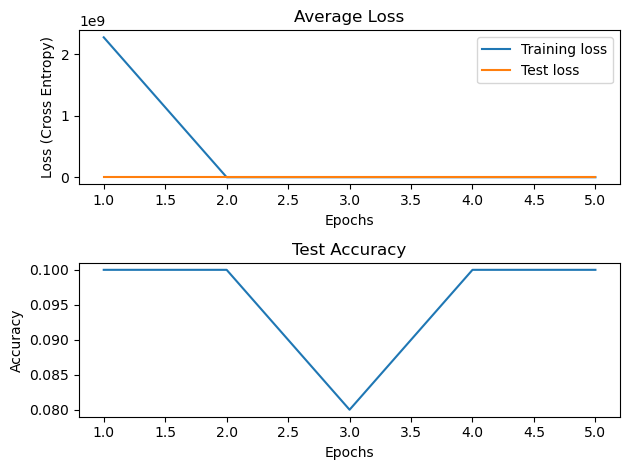

In [7]:
fig, axs = plt.subplots(2, 1)

axs[0].set_title('Average Loss')
axs[0].plot(range(1, num_epochs + 1), train_avg_loss, label='Training loss')
axs[0].plot(range(1, num_epochs + 1), test_avg_loss, label='Test loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss (Cross Entropy)')
axs[0].legend()

axs[1].set_title('Test Accuracy')
axs[1].plot(range(1, num_epochs + 1), test_accuracy)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [8]:
# save model
torch.save(network.state_dict(), 'trained.pth')